In [50]:
import pandas as pd
import numpy as np
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import geopandas as gpd

In [51]:
! pip install seaborn

"""
As preparation for this assignment, you'll spend time finding, loading, processing, assessing, and 
visualizing data in Jupyter notebooks. For the submission, you'll go back and either clean up some
of these notebooks, or create new ones synthesizing the key parts of the exploration you've done. 
The submitted notebooks should intersperse documentation, code, and output to create a clear narrative 
of your work. Only one set of notebooks is expected per team. The easies way to share them with the 
instructors is by uploading to GitHub, which we'll go over in class.
"""


# 1.0 Creating a dataframe of Bay Area Census Tracts


# 1.1 Downloading all California Census tracts


In [61]:
# download California census tracts

url = 'https://www2.census.gov/geo/tiger/TIGER2010/TRACT/2010/tl_2010_06_tract10.zip'

with open('tl_2010_06_tract10.zip', 'wb') as f:
    r = requests.get(url)
    f.write(r.content)

In [62]:
# Load the census tracts as a GeoDataFrame

tracts = gpd.read_file('zip://tl_2010_06_tract10.zip')  # 'zip://' prefix clarifies format

In [63]:
#Check it out!
tracts.head(2)

,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
0,06,083,002103,06083002103,21.03,Census Tract 21.03,G5020,S,2838200,7603,+34.9306689,-120.4270588,"POLYGON ((-120.41794 34.93834, -120.41766 34.9..."
1,06,083,002402,06083002402,24.02,Census Tract 24.02,G5020,S,16288573,44468,+34.9287963,-120.4780833,"POLYGON ((-120.47389 34.92081, -120.47428 34.9..."


# 1.2 Narrow to Bay Area Tracts

In [87]:
#Imports CSV list of Bay Area tracts
#(Could presumably have compiled 7 counties of tracts on python, but didn't have time. 
#Chose to do it this way instead)

BayAreaTracts = pd.read_csv('BayAreaTracts_csv.csv')
BayAreaTracts.head(2)

,Bay Area Tracts
0,6001400100
1,6001400200


In [90]:
#Adds leading zeroes to a new column
BayAreaTracts['BayAreaTracts_lz'] = BayAreaTracts['Bay Area Tracts'].apply(lambda x: '{0:0>11}'.format(x))
BayAreaTracts.head(2)

,Bay Area Tracts,BayAreaTracts_lz
0,6001400100,06001400100
1,6001400200,06001400200


In [91]:
#Selecting Bay Area census tracts from the main California tracts df
BayAreaTracts = tracts.loc[tracts['GEOID10'].isin(BayAreaTracts['BayAreaTracts_lz'])]
BayAreaTracts.head(2)

,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
921,06,085,509201,06085509201,5092.01,Census Tract 5092.01,G5020,S,1579162,0,+37.4012062,-122.0743461,"POLYGON ((-122.06955 37.40840, -122.06951 37.4..."
922,06,085,510500,06085510500,5105,Census Tract 5105,G5020,S,2590775,0,+37.3927828,-122.1201120,"POLYGON ((-122.11405 37.38211, -122.11405 37.3..."


In [92]:
#Add extra index column for convenience
BayAreaTracts.reset_index(inplace = True)
BayAreaTracts.reset_index(inplace = True)
BayAreaTracts.head(3)

,level_0,index,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
0,0,921,06,085,509201,06085509201,5092.01,Census Tract 5092.01,G5020,S,1579162,0,+37.4012062,-122.0743461,"POLYGON ((-122.06955 37.40840, -122.06951 37.4..."
1,1,922,06,085,510500,06085510500,5105,Census Tract 5105,G5020,S,2590775,0,+37.3927828,-122.1201120,"POLYGON ((-122.11405 37.38211, -122.11405 37.3..."
2,2,923,06,085,509401,06085509401,5094.01,Census Tract 5094.01,G5020,S,666430,0,+37.4069811,-122.1144543,"POLYGON ((-122.12005 37.40626, -122.12000 37.4..."


# 2.0 Fetching a street network for each tract

In [93]:
#This cell creates a function which gets the relevant osmnx network given a row of the dataframe
#First establishes the geometry of the tract, then gets the network within that geometry

def getNetwork(row):
    try:
        tract_polygon = BayAreaTracts.geometry[row['level_0']]
        tract_network = ox.graph_from_polygon(tract_polygon, network_type='drive')
        return tract_network
    except: 
        return 'Error'

                                             


In [94]:
#Applies getNetwork to every row, adds result to new column called 'tract network'

BayAreaTracts['Tract Network'] = BayAreaTracts.apply(getNetwork, axis=1)
BayAreaTracts.head(2)

<ipython-input-94-1336b65f1570>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BayAreaTracts['Tract Network'] = BayAreaTracts.apply(getNetwork, axis=1)


,level_0,index,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry,Tract Network
0,0,921,06,085,509201,06085509201,5092.01,Census Tract 5092.01,G5020,S,1579162,0,+37.4012062,-122.0743461,"POLYGON ((-122.06955 37.40840, -122.06951 37.4...","(26028045, 447946512, 65433883, 258107423, 656..."
1,1,922,06,085,510500,06085510500,5105,Census Tract 5105,G5020,S,2590775,0,+37.3927828,-122.1201120,"POLYGON ((-122.11405 37.38211, -122.11405 37.3...","(30674718, 30674727, 65416300, 65423382, 65423..."


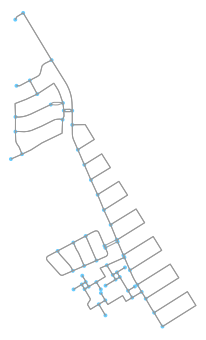

(<Figure size 321.835x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1e395770eb0>)

In [95]:
#Test
ox.plot_graph(tracts_AL.iloc[0]['Tract Network'])

# 3.0 Determining common metrics for ever census tract 

# 3.1 Average length of street segments between intersections

In [96]:
#Creating a function that churns out road length network

def mean_street_length(row):
    try:
        Edges=nx.to_pandas_edgelist(row['Tract Network'])
        mean_length = Edges['length'].mean()
        return mean_length
    except: 
        return 'Error'



In [98]:
#Create now column, apply mean_street_length to every row.

BayAreaTracts['mean_street_length'] = BayAreaTracts.apply(mean_street_length, axis=1)
BayAreaTracts.head(3)

<ipython-input-98-a7775daede79>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BayAreaTracts['mean_street_length'] = BayAreaTracts.apply(mean_street_length, axis=1)


,level_0,index,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry,Tract Network,mean_street_length
0,0,921,06,085,509201,06085509201,5092.01,Census Tract 5092.01,G5020,S,1579162,0,+37.4012062,-122.0743461,"POLYGON ((-122.06955 37.40840, -122.06951 37.4...","(26028045, 447946512, 65433883, 258107423, 656...",145.194
1,1,922,06,085,510500,06085510500,5105,Census Tract 5105,G5020,S,2590775,0,+37.3927828,-122.1201120,"POLYGON ((-122.11405 37.38211, -122.11405 37.3...","(30674718, 30674727, 65416300, 65423382, 65423...",108.795
2,2,923,06,085,509401,06085509401,5094.01,Census Tract 5094.01,G5020,S,666430,0,+37.4069811,-122.1144543,"POLYGON ((-122.12005 37.40626, -122.12000 37.4...","(26027653, 26027655, 26027656, 26029760, 26639...",148.184


# 3.2 Same as above, but for the percentage of 4-way intersections (basically a proxy for how close network is to a grid)


In [99]:
#Function that churns out percentage of four-way interections, given the row if the dataframe
def pctFourWay(row):
    try:
        #Get the tract network, then get a dictionary of the streets per node (osmnx function)
        nodes_dict=row['Tract Network'].graph['streets_per_node']
        
        #Turn it into a list, and count which are 4-way
        node_list=list(nodes_dict.values())
        four_way_pct = 100*node_list.count(4)/len(node_list)
        
        return four_way_pct
    except: 
        return 'Error'

In [100]:
#Create now column, apply function to every row.
BayAreaTracts['percent_four_way'] = BayAreaTracts.apply(pctFourWay, axis=1)
BayAreaTracts.head(3)

<ipython-input-100-0d9e81bd562a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BayAreaTracts['percent_four_way'] = BayAreaTracts.apply(pctFourWay, axis=1)


,level_0,index,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry,Tract Network,mean_street_length,percent_four_way
0,0,921,06,085,509201,06085509201,5092.01,Census Tract 5092.01,G5020,S,1579162,0,+37.4012062,-122.0743461,"POLYGON ((-122.06955 37.40840, -122.06951 37.4...","(26028045, 447946512, 65433883, 258107423, 656...",145.194,21.7822
1,1,922,06,085,510500,06085510500,5105,Census Tract 5105,G5020,S,2590775,0,+37.3927828,-122.1201120,"POLYGON ((-122.11405 37.38211, -122.11405 37.3...","(30674718, 30674727, 65416300, 65423382, 65423...",108.795,15.7895
2,2,923,06,085,509401,06085509401,5094.01,Census Tract 5094.01,G5020,S,666430,0,+37.4069811,-122.1144543,"POLYGON ((-122.12005 37.40626, -122.12000 37.4...","(26027653, 26027655, 26027656, 26029760, 26639...",148.184,26.8293


# 4.0 Export

In [101]:
#Drop network from df so I can save as shapefile

BayAreaTracts_shapefile = BayAreaTracts
BayAreaTracts_shapefile = BayAreaTracts_shapefile.drop(["Tract Network"], axis = 1)

In [103]:
#Save as shapefile
BayAreaTracts_shapefile.to_file("BayAreaTracts_shapefile.shp")